In [1]:
import pandas as pd
import numpy as np
import summarytools
import mysql.connector


# Inspect Data

In [2]:
# Connect with mysql database
connection = mysql.connector.connect(
    host='localhost',      # Replace with your database host
    user='root',  # Replace with your username
    password='1234',  # Replace with your password
    database='house'   # Replace with your database name
)

query = "SELECT * FROM house"
df = pd.read_sql(query, connection)
connection.close()


summarytools.dfSummary(df)

C:\Users\Ying\AppData\Local\Temp\ipykernel_21952\1775808620.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,address[object],1. 1102 BL (Amsterdamse Poort e.o2. 2132 HE (Hoofddorp Zuid)3. 1062 AC (Overtoomse Veld)4. 1441 DR (Binnenstad)5. 1013 BD (Houthavens)6. 2011 RZ (Bakenes)7. 3527 DZ (Kanaleneiland-Noord)8. 6222 CS (Limmel)9. 5611 EC (Binnenstad)10. 2288 DC (Plaspoelpolder)11. other,"19 (0.9%)11 (0.5%)11 (0.5%)9 (0.4%)6 (0.3%)5 (0.2%)5 (0.2%)5 (0.2%)4 (0.2%)4 (0.2%)2,122 (96.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA6NJREFUeJzt3DFuG1cYRtF/BEKxmiEIAlpCsgctwov1IriI7EEQNEXkqGGKpIngGHDhOwBzTiWwesUFH0nMp+V6vQ4U7vY+AP8fYiMjNjJiIyM2MmIjIzYyYiMjNjLLzDzMzFyv17edz8KNO5zP588zM8uyfBEcP9Pduq6ndV1PM3O/92G4bT6zkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZw7ZtL//8/b7rSbh5NghkFv8yi4p3NjLWVWSsq8j46YOM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmPhZMxeCHjnY2MwQsZgxcyfvogIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8ELGY+FkDF7I+MxGxjVKxrqKjHUVGZ/ZyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIWFeR8Vg4GesqMj6zkblbluW3ZVk+7X0Qbt/dzPw6M7/sfRBun2uUjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3M3cz8PjN/7n0Qbp8NAhnXKBmxkTF4IWPwQsY1SkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkrKvIWFeRcY2SERsZ6yoy1lVkXKNkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGQMXsgYvJBxjZIRGxmDFzIGL2Rco2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHGNkhEbGbGRsa4iY11FxjVKRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbGuoqMdRUZ1ygZsZExeCFj8ELGNUpGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxnXKJllZh5m5n7vg3BT3q/X69vHFw/n8/nzuq6nPU7Ebdq27WVZli8fgzus63p6enp6Ox6PX/c6HLfj9fX10+VyOT0/P9/PzL9jm5k5Ho9fHx8f/9jldNyih2+96AsCGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbmcPM34+F7H0QbsP3Wjps2/ZyuVxO8x+PhcCP2rbtZWbeP77usXB+hm8+Fm5dRcYXBDJiIyM2MmIjIzYyYiMjNjJiIyM2Mn8BS2qu7EAmsPMAAAAASUVORK5CYII="">",0(0.0%)
2,agent_name[object],1. Verhuurtbeter.nl2. Hausing3. Gruno Vastgoed B.V.4. HouseHunting Eindhoven5. Rotterdam Apartments6. Amsterdam Housing7. HouseHunting Randstad8. Rotsvast Eindhoven9. Huizenbalie.nl10. Rental Rotterdam11. other,"50 (2.3%)36 (1.6%)33 (1.5%)26 (1.2%)24 (1.1%)23 (1.0%)23 (1.0%)22 (1.0%)20 (0.9%)20 (0.9%)1,924 (87.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAABClJREFUeJzt3UFqG2cAhuHfQrj2ZoQQ+Bg+gA6Rw+YQOkDuYYxmEbnZuIsqwcmihaJ51arPswkRRMziZRQN/2ffvb+/Dyisrn0B/H+IjYzYyIiNjNjIiI2M2MiIjYzYyNyNMR7HGPcfXvv2/v5+utL1cMPWu93u0zRN2+8vzPP8end391lwXNp6mqbtfr8/bTabt+Px+HA4HLYvLy/3YwyxcVHrMcbYbDZvT09PX8+vPV7xerhhviCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZ9RhjHI/Hh49/whLW8zy/Hg6H7TifY5vn+XWM8e26l8UtskEgc+dHZlH59c7mrsZiflpXWVaxpNX3ddV+vz+do7v/238F/8CPddX575ZVLMZDXTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjI/DV5gSR8HL8YuLMqxcDIGL2Q+3tnc1VjUj8GLsQtLW03TtH1+fh7GLixtNcYYj4+Pv1/7Qrh9HuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRWY0xxul0+u3aF8LtW83z/PrlyxdjFxbnWDgZgxcyviCQ8TFKxrqKjHUVGesqMr4gkBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkbGuImNdRcaxcDLWVWTc2cgYvJAxeCFj8ELGQ10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOBZOxuCFjDsbGYMXMgYvZAxeyHioS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkbFBIGNdRcadjYx1FRnrKjLWVWQ81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8ELG4IWMY+FkDF7IuLORMXghY/BCxuCFjIe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHEsnIzBCxlfEMh8/xgdPkJZ2nq3230aYwzLKpa2mqZpa1lFwf/ZyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIrM+rqjEsq1iYY+FkrKvIuLORMXghY/BCxqMPMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kHAsnY/BC5uMvSoNfXfSX5613u92n8wYBfjLP8+slh1DraZq2+/3+tNls3i7xhtyG4/H4cDgcti8vL/djjMvENsYYm83m7enp6esl3pCb8njJN/OcjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcx6jD+Pk1z7Qvh3WaKJ9TzPr4fDYTsufJyE/77zGOpiQyjHwvkrFz0WbvBCxhcEMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwBxJKgWepp2XQAAAABJRU5ErkJggg=="">",0(0.0%)
3,agent_url[object],1. https://www.pararius.com/real-2. h

# Data Cleasing

In [3]:
df = df.drop(columns = ['address', 'agent_name', 'agent_url', 'house_name', 'description', 'house_url', 'maximum_months', 'minimum_months', 'status'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   available             1859 non-null   object 
 1   balcony               2010 non-null   object 
 2   city                  2201 non-null   object 
 3   construction_type     2040 non-null   object 
 4   deposit               1373 non-null   float64
 5   district              2201 non-null   object 
 6   dwelling_type         2201 non-null   object 
 7   energy_rating         1737 non-null   object 
 8   interior              1832 non-null   object 
 9   living_area_m2        2201 non-null   float64
 10  number_of_bathrooms   1540 non-null   float64
 11  number_of_bedrooms    1793 non-null   float64
 12  number_of_rooms       2201 non-null   int64  
 13  offered_since         2201 non-null   object 
 14  pets_allowed          904 non-null    object 
 15  price                

In [5]:
print(df['balcony'].unique()) # fillna with not present
print(df['construction_type'].unique()) # fillna with mode
print(df['dwelling_type'].unique())
print(df['interior'].unique()) # fillna using relationship
# print(df['property_type'].unique())
print(df['rental_agreement'].unique()) # fillna with not specified
print(df['smoking_allowed'].unique())
print(df['pets_allowed'].unique())

['Not present' 'Present' None]
['Existing building' 'New development' None]
['Flat' 'House' 'Room' 'Studio']
['Upholstered' 'Furnished' None 'Upholstered or furnished' 'Shell']
[None 'Unlimited period' 'Temporary rental']
[None 'No' 'Yes']
[None 'No' 'Yes']


In [6]:
df['balcony'] = df['balcony'].fillna('Not present')
df['construction_type'] = df['construction_type'].fillna(df['construction_type'].mode()[0])
df['interior'] = df['interior'].fillna('Not specified')
df['rental_agreement'] = df['rental_agreement'].fillna('Not specified')
df['pets_allowed'] = df['pets_allowed'].fillna('No')
df['smoking_allowed'] = df['smoking_allowed'].fillna('No')

In [7]:
# Impute number_of_bedrooms and number_of_bathrooms
median_bathrooms = int(df['number_of_bathrooms'].median())

# Imputation logic
def ImputeBedrooms(row):
    if pd.isnull(row['number_of_bedrooms']):
        # Set to 1 if dwelling type is 'room'
        if row['dwelling_type'] == 'room':
            return 1  
        elif not pd.isnull(row['number_of_rooms']) and not pd.isnull(row['number_of_bathrooms']):
            # If both rooms and bathrooms are not null 
            if row['number_of_rooms'] - row['number_of_bathrooms'] <= 0:
                return row['number_of_rooms'] 
            else:
                return row['number_of_rooms'] - row['number_of_bathrooms']
        elif not pd.isnull(row['number_of_rooms']):
            return row['number_of_rooms']
    return row['number_of_bedrooms']

def ImputeBathrooms(row):
    if pd.isnull(row['number_of_bathrooms']):
        return median_bathrooms 
    return row['number_of_bathrooms']

def TransformRooms(row):
    if row['dwelling_type'] != 'room':
        rooms = row['number_of_bathrooms'] + row['number_of_bedrooms']
        return rooms
    else:
        return 1

# Apply the logic
df['number_of_bedrooms'] = df.apply(ImputeBedrooms, axis=1)
df['number_of_bathrooms'] = df.apply(ImputeBathrooms, axis=1)
df['number_of_rooms'] = df.apply(TransformRooms, axis = 1)

df['number_of_bathrooms'] = df['number_of_bathrooms'].astype('int32')
df['number_of_bedrooms'] = df['number_of_bedrooms'].astype('int32')
df['number_of_rooms'] = df['number_of_rooms'].astype('int32')

In [8]:
# service cost category column
def CategorizeServiceCost(value):
    if pd.isnull(value) or value.lower() == 'none':  # Handle NaN or 'None'
        return 'Not specified'
    value = value.lower()
    if 'electricity' in value and 'gas' in value and 'water' in value and 'internet' in value:
        return 'All included'
    elif 'electricity' in value or 'gas' in value or 'water' in value or 'internet' in value:
        return 'Partial included'
    elif 'excludes' in value:
        return 'Not included'
    else:
        return 'Not specified'

df['service_cost_category'] = df['service_cost'].astype(str).apply(CategorizeServiceCost)

## Transform date columns

In [9]:
from datetime import datetime, timedelta
def StringToDate(value):
    if not pd.isnull(value):
        date = datetime.strptime(value,'%d-%m-%Y')
        return date

df['available'] = df['available'].apply(StringToDate)
df['offered_since'] = df['offered_since'].apply(StringToDate)

df['offer_to_available'] = (df['available'] - df['offered_since']).dt.days

median_duration = int(df['offer_to_available'].median())
df['offer_to_available'] = df['offer_to_available'].fillna(median_duration)

def AvailableFillNa(row):
    if pd.isnull(row['available']):
        date = row['offered_since'] + timedelta(days = median_duration)
        return date
    return row['available']

df['available'] = df.apply(AvailableFillNa, axis=1)

# extract month
month_dic = {1:'Jan.', 2: 'Feb.', 3: 'Mar.', 4: 'Apr.', 5: 'May.', 6: 'Jun.', 7: 'Jul', 8: 'Aug.', 9: 'Sep.', 10: 'Oct', 11: 'Nov.', 12: 'Dec'}
def GetMonth(value):
    return month_dic[value.month]

df['offered_month'] = df['offered_since'].apply(GetMonth)
df['available_month'] = df['available'].apply(GetMonth)



# house age
df['house_age'] = df['offered_since'].dt.year - df['year_of_construction']
df['house_age'] = df['house_age'].fillna(df['house_age'].median())
df = df.drop(columns = ['year_of_construction'])

df = df.drop(columns = ['available','offered_since'])


## Impute energy_rating

In [10]:
def ToIntegerScale(value):
    if value is not None:
        if value == 'G':
            return 1
        elif value == 'F':
            return 2
        elif value == 'E':
            return 3
        elif value == 'D':
            return 4
        elif value == 'C':
            return 5
        elif value == 'B':
            return 6
        elif value == 'A':
            return 7
        elif '+' in value:
            lis = list(value)
            extra = lis.count('+')
            return 7+extra
    return value

df['energy_rating'] = df['energy_rating'].apply(ToIntegerScale).astype('Int32')


In [11]:
train_data = df[df['energy_rating'].notna()]
correlation = train_data[['energy_rating', 'house_age', 'living_area_m2']].corr()
print(f"Correlation for house age and living_area_m2: {correlation}")

from scipy.stats import f_oneway

# ANOVA for city
anova_city = f_oneway(*(train_data[train_data['city'] == city]['energy_rating'] for city in train_data['city'].unique()))
print("ANOVA for City:", anova_city)

# ANOVA for dwelling_type
anova_dwelling = f_oneway(*(train_data[train_data['dwelling_type'] == dwelling_type]['energy_rating'] for dwelling_type in train_data['dwelling_type'].unique()))
print("ANOVA for Dwelling Type:", anova_dwelling)

Correlation for house age and living_area_m2:                 energy_rating  house_age  living_area_m2
energy_rating        1.000000  -0.311922       -0.088817
house_age           -0.311922   1.000000       -0.021225
living_area_m2      -0.088817  -0.021225        1.000000
ANOVA for City: F_onewayResult(statistic=np.float64(1.7275085632170124), pvalue=np.float64(1.7852169272406729e-09))
ANOVA for Dwelling Type: F_onewayResult(statistic=np.float64(22.19916064783507), pvalue=np.float64(3.022639099145275e-10))


In [12]:
from sklearn.ensemble import RandomForestClassifier

# Train data (rows without missing energy_rating)
train_data = df[df['energy_rating'].notna()]
X_train = train_data[['dwelling_type', 'city']]
y_train = train_data['energy_rating']

# Test data (rows with missing energy_rating)
test_data = df[df['energy_rating'].isna()]
X_test = test_data[['dwelling_type', 'city']]

# One-hot encoding for categorical features
# One-hot encoding for X_train
X_train_encoded = pd.get_dummies(X_train, drop_first=True)

# One-hot encoding for X_test
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align the columns of X_test_encoded with X_train_encoded
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Train model and predict
model = RandomForestClassifier()
model.fit(X_train_encoded, y_train)
df.loc[df['energy_rating'].isna(), 'energy_rating'] = model.predict(X_test_encoded)


## Impute deposit

In [13]:
train_data = df[df['deposit'].notna()]
correlation = train_data[['deposit','price']].corr()
print(f"Correlation for deposit and price: {correlation}")

# ANOVA for city
anova_city = f_oneway(*(train_data[train_data['city'] == city]['deposit'] for city in train_data['city'].unique()))
print("ANOVA for City:", anova_city)

# ANOVA for dwelling type
anova_dwelling = f_oneway(*(train_data[train_data['dwelling_type'] == dwelling_type]['deposit'] for dwelling_type in train_data['dwelling_type'].unique()))
print("ANOVA for Dwelling_type:", anova_dwelling)


Correlation for deposit and price:           deposit     price
deposit  1.000000  0.900232
price    0.900232  1.000000
ANOVA for City: F_onewayResult(statistic=np.float64(5.5684035498783695), pvalue=np.float64(2.671917670885024e-76))
ANOVA for Dwelling_type: F_onewayResult(statistic=np.float64(94.71167235855725), pvalue=np.float64(1.060761334956301e-55))


In [14]:
# Impute deposit by city and dwelling_type
df['deposit'] = df['deposit'].fillna(
    df.groupby(['city', 'dwelling_type'])['deposit'].transform('median')
)

df['deposit'] = df['deposit'].fillna(df['deposit'].median())


## Inspect multicollinearity

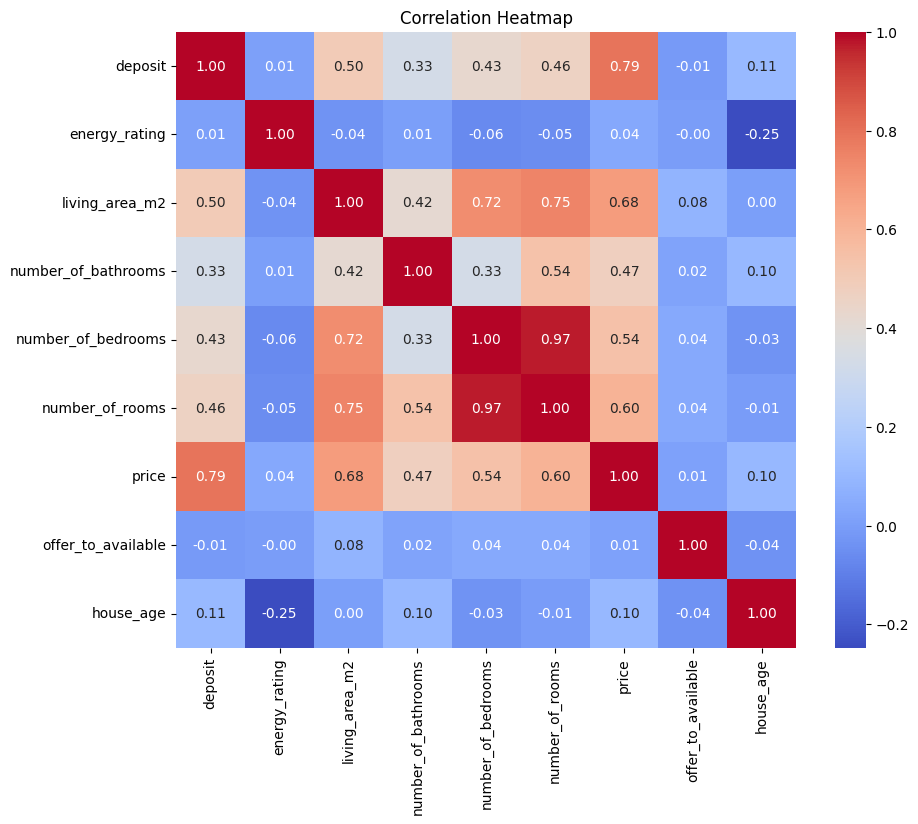

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter numerical columns
numerical_features = df.select_dtypes(include=['float64', 'int32'])

# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap")
plt.show()


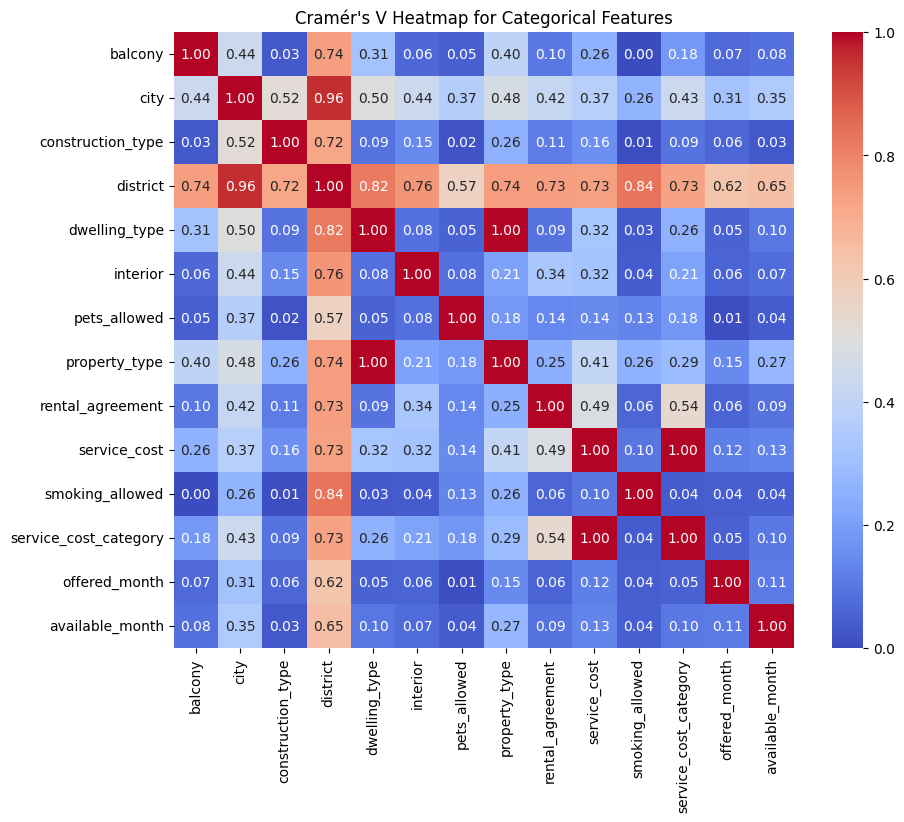

In [16]:
from scipy.stats import chi2_contingency

def cramers_v(contingency_table):
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# Function to calculate Cramér's V matrix
def cramers_v_matrix(df, categorical_features):
    matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)
    for col1 in categorical_features:
        for col2 in categorical_features:
            contingency_table = pd.crosstab(df[col1], df[col2])
            matrix.loc[col1, col2] = cramers_v(contingency_table)
    return matrix.astype(float)

# List of categorical features
categorical_features = ['balcony', 'city', 'construction_type',
       'district', 'dwelling_type', 'interior',
       'pets_allowed', 'property_type', 'rental_agreement', 'service_cost', 'smoking_allowed',
       'service_cost_category', 'offered_month', 'available_month']

# Compute Cramér's V matrix
cramers_v_matrix_df = cramers_v_matrix(df, categorical_features)

# Ensure diagonal elements are 1
np.fill_diagonal(cramers_v_matrix_df.values, 1)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Cramér's V Heatmap for Categorical Features")
plt.show()


In [17]:
df = df.drop(columns = ['property_type', 'district', 'service_cost', 'number_of_bedrooms'])

## Reduce dimensionality of data

In [18]:
categorical_features = ['balcony', 'city', 'construction_type', 'dwelling_type', 
                        'interior', 'pets_allowed', 'rental_agreement', 
                        'smoking_allowed','service_cost_category', 'offered_month', 
                        'available_month']

threshold = 0.05 * len(df)  # Adjust threshold based on dataset size
for col in categorical_features:
    rare_categories = df[col].value_counts()[df[col].value_counts() < threshold].index
    df[col] = df[col].replace(rare_categories, 'Other')

## One-Hot Encoding

In [19]:
df.columns

Index(['balcony', 'city', 'construction_type', 'deposit', 'dwelling_type',
       'energy_rating', 'interior', 'living_area_m2', 'number_of_bathrooms',
       'number_of_rooms', 'pets_allowed', 'price', 'rental_agreement',
       'smoking_allowed', 'service_cost_category', 'offer_to_available',
       'offered_month', 'available_month', 'house_age'],
      dtype='object')

In [20]:
from sklearn.preprocessing import OneHotEncoder
df = pd.get_dummies(df, columns = ['balcony','city','construction_type', 'dwelling_type', 'interior', 'pets_allowed', 'rental_agreement',
                                   'smoking_allowed', 'service_cost_category', 'offered_month', 'available_month'])
df.head()

,deposit,energy_rating,living_area_m2,number_of_bathrooms,number_of_rooms,price,offer_to_available,house_age,balcony_Not present,balcony_Present,city_Amsterdam,city_Den Haag,city_Eindhoven,city_Maastricht,city_Other,city_Rotterdam,construction_type_Existing building,construction_type_Other,dwelling_type_Flat,dwelling_type_House,dwelling_type_Other,dwelling_type_Room,interior_Furnished,interior_Not specified,interior_Other,interior_Shell,interior_Upholstered,pets_allowed_No,pets_allowed_Other,rental_agreement_Not specified,rental_agreement_Temporary rental,rental_agreement_Unlimited period,smoking_allowed_No,smoking_allowed_Other,service_cost_category_All included,service_cost_category_Not included,service_cost_category_Not specified,service_cost_category_Partial included,offered_month_Dec,offered_month_Nov.,offered_month_Other,available_month_Dec,available_month_Feb.,available_month_Jan.,available_month_Other
0,3500.0,6,81.0,1,3,1750.0,21.0,19.0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,True,True,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False
1,3600.0,7,67.0,1,2,1800.0,2.0,14.0,False,True,False,False,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,False
2,2000.0,7,54.0,1,2,1100.0,21.0,6.0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False
3,2000.0,3,42.0,1,2,845.0,21.0,45.0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,True,True,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False
4,2000.0,7,40.0,1,2,1200.0,14.0,0.0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False


## Inspect distribution

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 45 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   deposit                                 2201 non-null   float64
 1   energy_rating                           2201 non-null   Int32  
 2   living_area_m2                          2201 non-null   float64
 3   number_of_bathrooms                     2201 non-null   int32  
 4   number_of_rooms                         2201 non-null   int32  
 5   price                                   2201 non-null   float64
 6   offer_to_available                      2201 non-null   float64
 7   house_age                               2201 non-null   float64
 8   balcony_Not present                     2201 non-null   bool   
 9   balcony_Present                         2201 non-null   bool   
 10  city_Amsterdam                          2201 non-null   bool

deposit - min: 4.0, max: 16000.0
energy_rating - min: 1, max: 12
living_area_m2 - min: 7.0, max: 708.0
number_of_bathrooms - min: 1, max: 5
number_of_rooms - min: 2, max: 13
price - min: 200.0, max: 12000.0
offer_to_available - min: 0.0, max: 381.0
house_age - min: -1.0, max: 1019.0


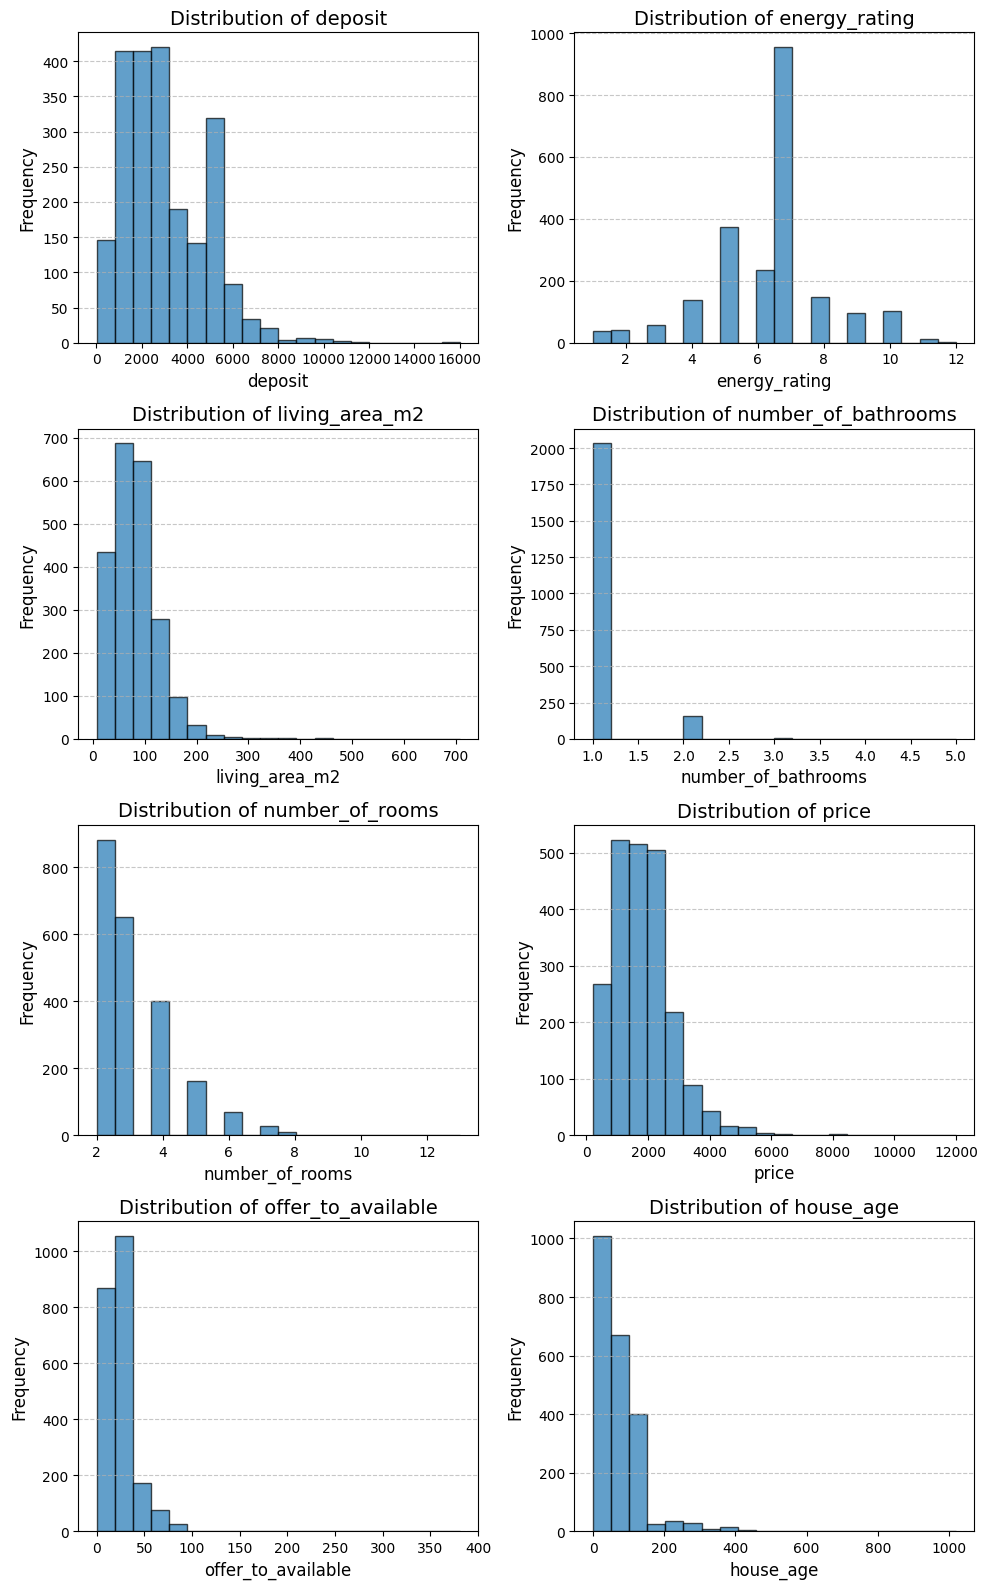

In [22]:
# Select numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int32']).columns

import math
import matplotlib.pyplot as plt

# Calculate the number of rows needed (2 plots per row)
num_cols = 2
num_rows = math.ceil(len(numeric_columns) / num_cols)

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4 * num_rows))
# Flatten the axes array for easy iteration
axes = axes.flatten()  

# Loop through numeric columns and plot
for i, column in enumerate(numeric_columns):
    axes[i].hist(df[column].dropna(), bins=20, edgecolor='k', alpha=0.7)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].set_title(f'Distribution of {column}', fontsize=14)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    print(f"{column} - min: {df[column].min()}, max: {df[column].max()}")

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust spacing
plt.show()



# Split and transform data

In [23]:
# Split the data for the common use
from sklearn.model_selection import train_test_split
X = df.drop(columns = ['price']).copy()
y = df['price'].copy()
# split data to train + test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [24]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: Log-transform numeric columns (excluding already excluded ones)
numeric_columns = df.select_dtypes(include=['float64', 'int32']).drop(
    columns=['energy_rating', 'price', 'number_of_bathrooms', 'number_of_rooms', 'house_age']
).columns

for c in numeric_columns:
    X_train[c] = np.log1p(X_train[c])  # Use log1p to handle zero values safely
    X_test[c] = np.log1p(X_test[c])

# Step 2: Shift and log-transform 'house_age'
dfs = {'X_train': X_train, 'X_test': X_test}  # Use dictionary for better management
shift_age_value = abs(X_train['house_age'].min()) + 1  # Calculate shift value from training data

for name, d in dfs.items():
    d['house_age'] = np.log1p(d['house_age'] + shift_age_value)  # Apply consistent transformation

# Step 3: Transform 'number_of_rooms' with square root and scale
scaler_rooms = StandardScaler()  # Initialize one scaler for consistent scaling
X_train['number_of_rooms'] = scaler_rooms.fit_transform(np.sqrt(X_train[['number_of_rooms']]))
X_test['number_of_rooms'] = scaler_rooms.transform(np.sqrt(X_test[['number_of_rooms']]))

# Step 4: Transform target variable (if needed for modeling)
y_train = np.log1p(y_train)  # Log-transform the target variable
y_test = np.log1p(y_test)



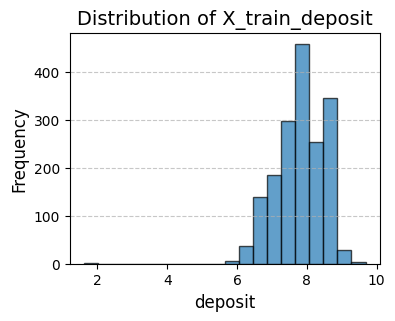

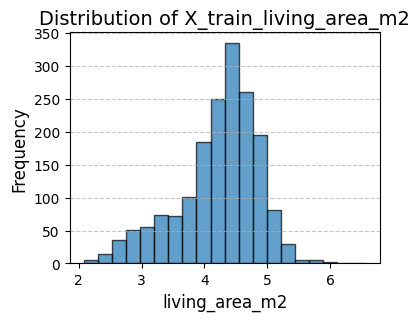

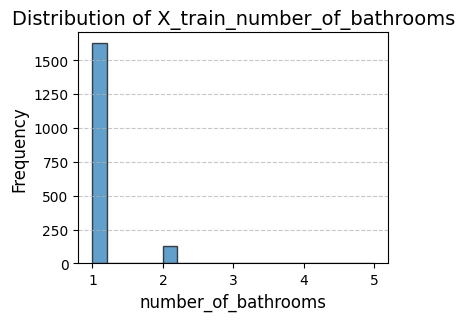

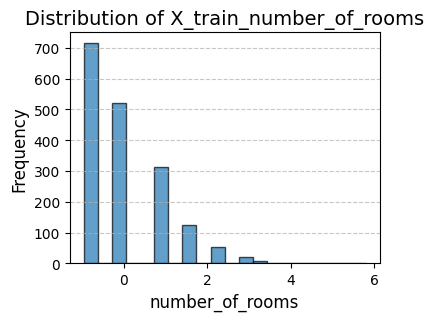

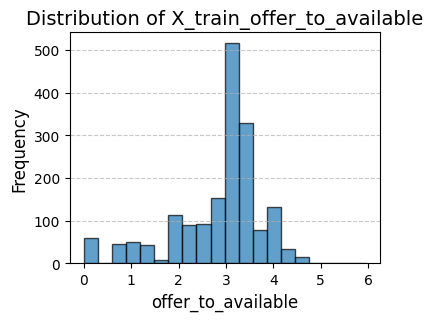

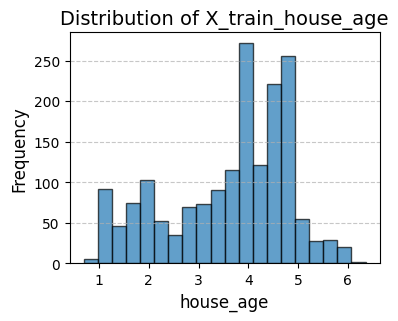

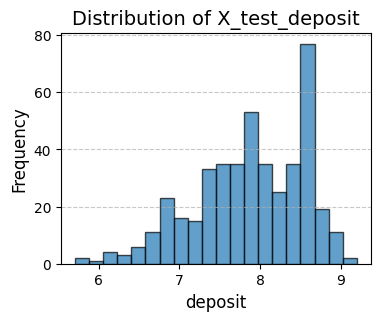

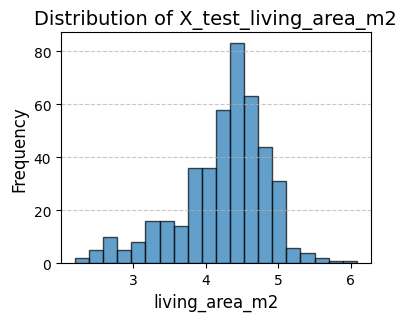

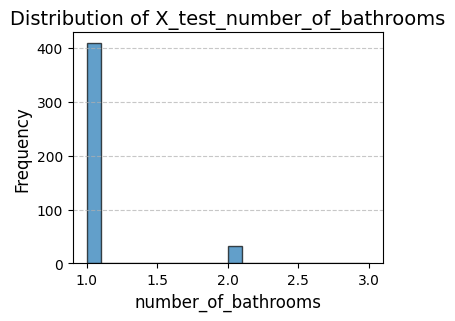

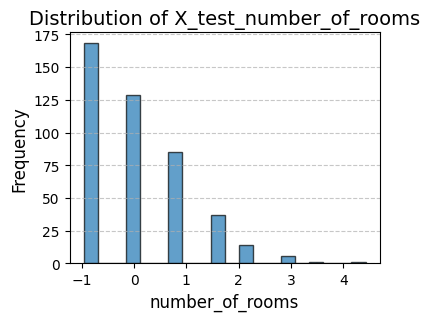

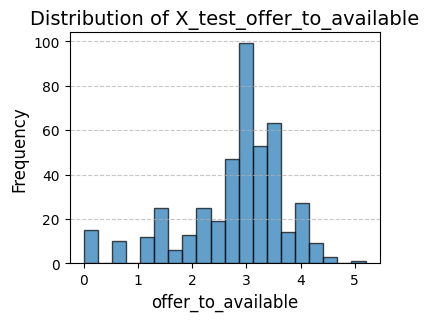

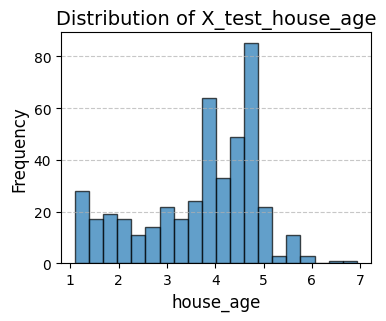

In [25]:
dfs = {'X_train': X_train, 'X_test': X_test}  # Use a dictionary to associate names with DataFrames
numeric_columns = X_train.select_dtypes(include=['float64', 'int32']).drop(columns=['energy_rating']).columns

for name, d in dfs.items():  # Iterate through the dictionary
    for column in numeric_columns:
        plt.figure(figsize=(4, 3))  # Set figure size
        plt.hist(d[column].dropna(), bins=20, edgecolor='k', alpha=0.7)  # Drop NaNs and plot histogram
        plt.xlabel(column, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title(f'Distribution of {name}_{column}', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add gridlines
        plt.show()


# ML models

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import shap

d:\Side Projects\Scrapy_Pararius\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Adj r2 = 1-(1-R2)*(n-1)/(n-p-1)

def result(alg_model, X_test, y_test):
  y_pred = alg_model.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  n = len(y_test)
  p = len(X_test.columns)
  adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
  print('Mean Absolute Error: {}\n\nMean Squared Error:\n {}\n\nR-Squared: {}\n\nAdjusted R-Squared:\n {}'
      .format(mean_absolute_error(y_test,y_pred), mean_squared_error(y_test,y_pred),r2_score(y_test, y_pred),adj_r2))
def gridCVModel(algorithm, X_train, y_train, grid):
  # https://www.projectpro.io/recipes/find-optimal-parameters-using-randomizedsearchcv-for-regression
  # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
  # https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
  scoring = {'Negative Mean Absolute Error':'neg_mean_absolute_error','Negative Mean Squared Error':'neg_mean_squared_error', 'R-Squared':'r2'}
  randm_src = RandomizedSearchCV(estimator=algorithm, param_distributions = grid, cv = 5, n_iter = 10, n_jobs=-1,
                                 scoring = scoring,refit='Negative Mean Absolute Error', random_state = 42)
  randm_src.fit(X_train, y_train)

  print(" Results from Random Search " )
  print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
  print("\n The best score across ALL searched params:\n", randm_src.best_score_)
  print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)
  # Calculate and print scores for the best estimator
  best_estimator = randm_src.best_estimator_
  for score_name, score_func in scoring.items():
      score = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring=score_func)
      print(f"\n {score_name} score for the best estimator: {score.mean()}")


def model(algorithm, X_train, X_test, y_train, y_test):
  # Evaluate the model
  alg_model = algorithm.fit(X_train, y_train)
  result(alg_model, X_test, y_test)
  parameters = alg_model.get_params()
  print(f"Parameters of the model: {parameters}")

## Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
print('Linear Regression Model \n')
model(reg, X_train, X_test, y_train, y_test)

Linear Regression Model 

Mean Absolute Error: 0.1620943453824865

Mean Squared Error:
 0.04653670810244943

R-Squared: 0.8486709392352978

Adjusted R-Squared:
 0.8318565991503308
Parameters of the model: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


## Ridge Model

In [36]:
from sklearn.linear_model import Ridge
ridge = Ridge()

alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['auto', 'svd', 'cholesky', 'lsqr']
fit_intercept = [True]
tol = [1e-4, 1e-3, 1e-2] 

random_grid = {'alpha': alpha,
               'solver': solver,
               'fit_intercept': fit_intercept,
               'tol': tol}

gridCVModel(ridge, X_train, y_train, random_grid)


 Results from Random Search 

 The best estimator across ALL searched params:
 Ridge(alpha=0.01, solver='lsqr', tol=0.001)

 The best score across ALL searched params:
 -0.16948321888009044

 The best parameters across ALL searched params:
 {'tol': 0.001, 'solver': 'lsqr', 'fit_intercept': True, 'alpha': 0.01}

 Negative Mean Absolute Error score for the best estimator: -0.16948321888009044

 Negative Mean Squared Error score for the best estimator: -0.0523017565362184

 R-Squared score for the best estimator: 0.831582827026528


In [37]:
print("Ridge model test performance:\n")
ridge_tuned = Ridge(tol = 0.001, solver = 'lsqr', fit_intercept = True, alpha = 0.01)
model(ridge_tuned, X_train, X_test, y_train, y_test)

Ridge model test performance:

Mean Absolute Error: 0.16186793986095319

Mean Squared Error:
 0.04647691661419367

R-Squared: 0.8488653704730972

Adjusted R-Squared:
 0.8320726338589969
Parameters of the model: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'lsqr', 'tol': 0.001}


## Decision Tree

In [30]:
from sklearn.tree import DecisionTreeRegressor

#
tree = DecisionTreeRegressor(random_state = 42)

# The maximum depth of the tree.
max_depth = np.arange(3, 16, 2).tolist()
# The minimum number of samples required to split an internal node:
min_samples_split = np.linspace(2, 10, num=5, dtype=int).tolist()
# The minimum number of samples required to be at a leaf node
min_samples_leaf = np.array([1, 2, 3, 5]).tolist()
# The number of features to consider when looking for the best split:
max_features = [None, 'sqrt', 'log2']
# A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
min_impurity_decrease = [0, 0.001, 0.01, 0.1]
# Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
max_leaf_nodes = np.linspace(10, 50, num=5, dtype=int).tolist()
# The function to measure the quality of a split.
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']


random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'min_impurity_decrease': min_impurity_decrease,
               'max_leaf_nodes': max_leaf_nodes,
               'criterion': criterion}

gridCVModel(tree, X_train, y_train, random_grid)

 Results from Random Search 

 The best estimator across ALL searched params:
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=15, max_leaf_nodes=30,
                      min_impurity_decrease=0.001, min_samples_leaf=5,
                      random_state=42)

 The best score across ALL searched params:
 -0.18735888846259513

 The best parameters across ALL searched params:
 {'min_samples_split': 2, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 30, 'max_features': None, 'max_depth': 15, 'criterion': 'friedman_mse'}

 Negative Mean Absolute Error score for the best estimator: -0.18735888846259513

 Negative Mean Squared Error score for the best estimator: -0.06285023884441387

 R-Squared score for the best estimator: 0.7977414577560282


In [31]:
print("Decision Tree Test Performance:\n")
tree_tuned = DecisionTreeRegressor(random_state = 42, min_samples_split= 2, min_samples_leaf = 5, min_impurity_decrease= 0.001, 
                                   max_leaf_nodes= 30, max_features= None, max_depth= 15, criterion = 'friedman_mse' )
model(tree_tuned, X_train, X_test, y_train, y_test)

Decision Tree Test Performance:

Mean Absolute Error: 0.1835226696969198

Mean Squared Error:
 0.05999165979287575

R-Squared: 0.8049178401234273

Adjusted R-Squared:
 0.7832420445815859
Parameters of the model: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


## Random Forest

In [39]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)

# Number of trees
n_estimators = [50, 100, 200, 500, 1000]
# tree depth
max_depth = [None, 5, 10, 20, 50]
# minimum samples to split
min_samples_split = [2, 5, 10, 20]
# minimum samples per leaf
min_samples_leaf = [1, 2, 5, 10]
# Features for splits
max_features = ['sqrt', 'log2', None, 0.5, 0.8]
# Bootstrapping
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 
               'min_samples_leaf': min_samples_leaf, 'max_features': max_features, 'bootstrap': bootstrap}

gridCVModel(rf, X_train, y_train, random_grid)

 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(bootstrap=False, max_depth=10, max_features=0.5,
                      min_samples_leaf=5, min_samples_split=10,
                      n_estimators=200, random_state=42)

 The best score across ALL searched params:
 -0.14794333065339796

 The best parameters across ALL searched params:
 {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.5, 'max_depth': 10, 'bootstrap': False}

 Negative Mean Absolute Error score for the best estimator: -0.14794333065339796

 Negative Mean Squared Error score for the best estimator: -0.04331183839313092

 R-Squared score for the best estimator: 0.8609500476059854


In [41]:
print('Random Forest Test Performance:\n')
rf_tuned = RandomForestRegressor(random_state= 42, n_estimators = 200, min_samples_split = 10, min_samples_leaf = 5,
                        max_features = 0.5, max_depth = 10, bootstrap = False)

model(rf_tuned, X_train, X_test, y_train, y_test)


Random Forest Test Performance:

Mean Absolute Error: 0.1429461451964323

Mean Squared Error:
 0.03971350496711329

R-Squared: 0.8708587768366179

Adjusted R-Squared:
 0.8565097520406866
Parameters of the model: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 0.5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
